<a href="https://colab.research.google.com/github/Pravallika41296/IANNWTF_Homework_Group24/blob/gh-pages/IANNWTF_Homework06_Group24_Vedant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importing all the necessary packages
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

In [3]:
(train_images, train_label), (test_images, test_label) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [4]:
test_label = test_label.flatten()
train_label = train_label.flatten()

In [5]:
print(train_images.shape)
print(train_label.shape)
print(test_images.shape)
print(test_label.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [6]:
train_label = tf.data.Dataset.from_tensor_slices(train_label)

train_label = train_label.map(lambda t : tf.one_hot(t, 10))
test_label = tf.data.Dataset.from_tensor_slices(test_label)

test_label = test_label.map(lambda t : tf.one_hot(t, 10))

In [7]:
train_images = tf.data.Dataset.from_tensor_slices(train_images)
test_images = tf.data.Dataset.from_tensor_slices(test_images)

train_images = train_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

test_images = test_images.map(lambda img : tf.cast(2*(img/255)-1, tf.float32))

In [8]:
train_dataset = tf.data.Dataset.zip((train_images, train_label))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.shuffle(buffer_size=500)

#zipping the test sequences and labels 
test_dataset = tf.data.Dataset.zip((test_images, test_label))
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.shuffle(buffer_size=100)

In [9]:
class ResidualBlock(tf.keras.layers.Layer):
  
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.layers_list = [
    tf.keras.layers.Conv2D(filters=channels, kernel_size=1, padding='SAME'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=channels, kernel_size=3, padding='SAME'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=channels, kernel_size=1, padding='SAME'),
    tf.keras.layers.BatchNormalization()]

    @tf.function
    def call(self, x, training):
        # Define the forward step.
        for layer in self.layers_list:
          y = layer(x, training = training)
        y = y + x
        return x

In [10]:
class ResNet(tf.keras.Model):

  def __init__(self, num_blocks=2, channels_in_block=10):

    super(ResNet, self).__init__()

    # you can define a set of layes to put in front of your custom blocks
    self.pre_block = [tf.keras.layers.Conv2D(filters=channels_in_block, kernel_size=1, padding='SAME')]
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.pre_block.append(tf.keras.layers.AveragePooling2D(strides=2))
    # now you can use your self defined blocks much like layers
    self.blocks = []
    for _ in range(num_blocks):
        self.blocks.append(ResidualBlock(channels=channels_in_block))


    # concatenation layer    
    self.concat = tf.keras.layers.Concatenate()
    
    # readout layers
    self.post_blocks = []
    self.post_blocks.append(tf.keras.layers.GlobalAveragePooling2D())
    self.post_blocks.append(tf.keras.layers.Dense(units=10, activation= 'softmax'))

   

    
  def call(self, x, training_flag=True):

      # pass input through pre_block layers
      # you can pass the training flag to every layer in tf
      for l in self.pre_block:
        x = l(x, training=training_flag)

      # concatenate blocks input and blocks output
      y = x
      for b in self.blocks:
        y = b(y)
      # the concatenation layer has to be called with a list of 
      # ! again fictional architecture !
      y = self.concat([y,x])
      
      # readout layers
      for b in self.post_blocks:
        y = b(y)

      # make sure prediction and target dimension match
      y = tf.expand_dims(y, axis=1)

      return y

In [17]:
class DenseBlock(tf.keras.layers.Layer):
  def conv(x,filters,kernel=1,strides=1):    
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
    return x
  
  def __init__(self, repetition, x):
    super(DenseBlock, self).__init__()
    for _ in range(repetition):
      y = conv(x, 4*filters)
      y = conv(y, filters, 3)
      dense = concatenate([y,x])
    return y

  def call(self, x):
    dense = self.concat([y,x])
    return dense



In [26]:
class DenseNet(tf.keras.Model):

  def __init__(self, num_blocks=2, channels_in_block=10):

    super(DenseNet, self).__init__()
    # you can define a set of layes to put in front of your custom blocks
    self.pre_block = [tf.keras.layers.Conv2D(64, kernel_size=1, padding='SAME')]
    self.pre_block.append(tf.keras.layers.BatchNormalization())
    self.pre_block.append(tf.keras.layers.AveragePooling2D(strides=2))
    # now you can use your self defined blocks much like layers
    self.blocks = []
    for _ in range(num_blocks):
        self.blocks.append(DenseBlock())


    # concatenation layer    
    self.concat = tf.keras.layers.Concatenate()
    
    # readout layers
    self.post_blocks = []
    self.post_blocks.append(tf.keras.layers.GlobalAveragePooling2D())
    self.post_blocks.append(tf.keras.layers.Dense(units=10, activation= 'softmax'))

   

    
  def call(self, x, training_flag=True):

      # pass input through pre_block layers
      # you can pass the training flag to every layer in tf
      for l in self.pre_block:
        x = l(x, training=training_flag)

      # concatenate blocks input and blocks output
      y = x
      for b in self.blocks:
        y = b(y)
      # the concatenation layer has to be called with a list of 
      # ! again fictional architecture !
      y = self.concat([y,x])
      
      # readout layers
      for b in self.post_blocks:
        y = b(y)

      # make sure prediction and target dimension match
      y = tf.expand_dims(y, axis=1)

      return y
  


In [11]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (image, target) in test_data:
    prediction = model(image)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



In [12]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 30
learning_rate = 0.0001
running_average_factor = 0.95

# Initialize the model.
model = ResNet()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



ValueError: ignored

In [13]:
model.summary()

Model: "res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  40        
_________________________________________________________________
batch_normalization (BatchNo multiple                  40        
_________________________________________________________________
average_pooling2d (AveragePo multiple                  0         
_________________________________________________________________
residual_block (ResidualBloc multiple                  0         
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  0         
_________________________________________________________________
concatenate (Concatenate)    multiple                  0         
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0   

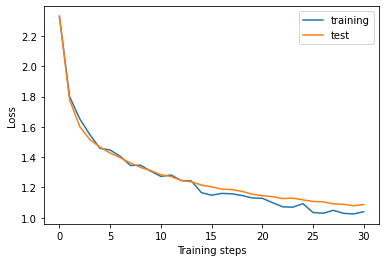

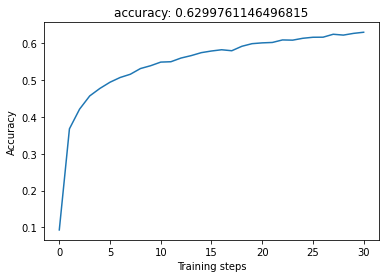

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()